# Housing Unit Allocation Full Workflow

## Overview
Given a building inventory that uses IN-CORE standard columns, run housing unit allocation.
This process checks to see if the housing unit inventory is available and if not it will create it.
This process checks to see if the address point inventory is available and if not it will create it.

With the housing unit inventory and address point inventory created, they will be uploaded to IN-CORE Dataservice.

With the required files on IN-CORE Dataservice, the housing unit allocation method will run.
Functions are provided to obtain and clean data required for the version 2 Housing Unit Allocation. 

## Required Inputs
Program requires the following inputs:
1. Building inventory file from pyincore
    - IN-CORE account
    
## Output Description
The output of this workflow is a CSV file with the housing unit inventory allocated to a building inventory using the housing unit allocation model.

The output CSV is designed to be used in the Interdependent Networked Community Resilience Modeling Environment (IN-CORE).

IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/


## Instructions
Users can run the workflow by executing each block of code in the notebook.

## Description of Program
- program:    ncoda_07cv1_run_HUA_workflow
- task:       Start with building inventory and run housing unit allocation algorithm
- See github commits for description of program updates
- Current Version:    2022-08-29 - v2 workflow
- 2022-10-06 - clean up code and test output for Salt Lake City
- project:    Interdependent Networked Community Resilience Modeling Environment (IN-CORE), Subtask 5.2 - Social Institutions
- funding:	  NIST Financial Assistance Award Numbers: 70NANB15H044 and 70NANB20H008 
- author:     Nathanael Rosenheim

- Suggested Citation:
Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. 
https://doi.org/10.17603/ds2-jwf6-s535.

## Setup Python Environment

In [2]:
import pandas as pd
import geopandas as gpd # For reading in shapefiles
import numpy as np
import sys # For displaying package versions
import os # For managing directories and file paths if drive is mounted

from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore.analyses.buildingdamage.buildingdamage import BuildingDamage

from pyincore_viz.geoutil import GeoUtil as viz

In [32]:
# To reload submodules need to use this magic command to set autoreload on
%load_ext autoreload
%autoreload 2
# open, read, and execute python program with reusable commands
from pyncoda.ncoda_00b_directory_design import directory_design
from pyncoda.ncoda_07a_generate_hui import generate_hui_functions
from pyncoda.ncoda_07c_generate_addpt import generate_addpt_functions
from pyncoda.ncoda_07d_run_hua_workflow import hua_workflow_functions


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import scooby # Reports Python environment

In [5]:
# Generate report of Python environment
print(scooby.Report(additional=['pandas','pyincore','pyincore_viz']))


--------------------------------------------------------------------------------
  Date: Fri Oct 07 16:13:41 2022 Central Daylight Time

                OS : Windows
            CPU(s) : 12
           Machine : AMD64
      Architecture : 64bit
               RAM : 31.6 GiB
       Environment : Jupyter

  Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:50:36) [MSC
  v.1929 64 bit (AMD64)]

            pandas : 1.5.0
          pyincore : 1.7.0
      pyincore_viz : Version unknown
             numpy : 1.23.3
             scipy : 1.9.1
           IPython : 8.5.0
        matplotlib : 3.6.0
            scooby : 0.5.12
--------------------------------------------------------------------------------


In [6]:
# Check working directory - good practice for relative path access
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\IN-CORE\\Tasks\\PublishHUIv2\\HousingUnitInventories_2022-03-03\\ReplicationCode\\intersect-community-data'

In [7]:
# Edit Data Dictionary for Community

# Example of data dictionary for one community with one county
# Check how to capitalize the state name at
## https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/
'''
communities = {'Mobile_AL' : {
                    'community_name' : 'Mobile, AL',
                    'STATE' : 'ALABAMA',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '01097', 'Name' : 'Mobile County, AL'}}}}
'''


communities = {'SaltLakeCity_UT' : {
                    'community_name' : 'Salt Lake City, UT',
                    'STATE' : 'UTAH',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '49035', 'Name' : 'Salt Lake City County, UT'}}}}

## Step 1: Set up pyincore and read in data
IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/

Registration is free.

In [8]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
#client.clear_cache() 

Connection successful to IN-CORE services. pyIncore version detected: 1.7.0


In [9]:
# create data_service object for loading files
data_service = DataService(client)

## Read in Housing Unit Inventory or create a new one

In [10]:
version = '2.0.0'
version_text = 'v2-0-0'

# Save Outputfolder - due to long folder name paths output saved to folder with shorter name
# files from this program will be saved with the program name - 
# this helps to follow the overall workflow
outputfolder = "OutputData"

# Set random seed for reproducibility
seed = 1000
basevintage = 2010

generate_hui_df = generate_hui_functions(
                    communities =   communities,
                    seed =          seed,
                    version =       version,
                    version_text=   version_text,
                    basevintage=    basevintage,
                    outputfolder=   outputfolder
                    )

hui_dataset_id = generate_hui_df.generate_hui_v2_for_incore()

Generating Housing Unit Inventory v2.0.0 data for Salt Lake City, UT
Connection successful to IN-CORE services. pyIncore version detected: 1.7.0
Number of datasets matching Housing Unit Inventory v2.0.0 data for Salt Lake City, UT: 1
Dataset Housing Unit Inventory v2.0.0 data for Salt Lake City, UT already exists in IN-CORE
Dataset already exists in IN-CORE with filename hui_v2-0-0_SaltLakeCity_UT_2010_rs1000.csv
Use dataset_id: 630e8b03f5438e1f8c51d7c2
Dataset already exists on IN-CORE, use dataset_id: 630e8b03f5438e1f8c51d7c2


In [11]:
# Housing Unit inventory
housing_unit_inv_id = hui_dataset_id
# load housing unit inventory as pandas dataframe
housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
filename = housing_unit_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\630e8b03f5438e1f8c51d7c2\hui_v2-0-0_SaltLakeCity_UT_2010_rs1000\hui_v2-0-0_SaltLakeCity_UT_2010_rs1000.csv


In [12]:
housing_unit_inv_df = pd.read_csv(filename, header="infer")

In [13]:
housing_unit_inv_df['huid'].describe()

count                   364210
unique                  364210
top       B490351001001006H001
freq                         1
Name: huid, dtype: object

## Read in Building Inventory

In [14]:
# Building inventory
bldg_inv_id = "62fea288f5438e1f8c515ef8" # SLC building inventory - Milad Roohi
# load building inventory
bldg_inv = Dataset.from_data_service(bldg_inv_id, data_service)
filename = bldg_inv.get_file_path('shp')
print("The IN-CORE Dataservice has saved the Building Inventory on your local machine: "+filename)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
The IN-CORE Dataservice has saved the Building Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\62fea288f5438e1f8c515ef8\Salt Lake County All Building\Salt Lake County All Building.shp


In [15]:
bldg_inv_gdf = gpd.read_file(filename)
# Check CRS of building inventory
bldg_inv_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
from pyproj import CRS
# Update CRS to EPSG:4326 if not already in that format
if bldg_inv_gdf.crs != CRS.from_epsg(4326):
    bldg_inv_gdf = bldg_inv_gdf.to_crs(epsg=4326)
    print("The CRS of the building inventory has been updated to EPSG:4326")
else:
    print("The CRS of the building inventory is already in EPSG:4326")

The CRS of the building inventory is already in EPSG:4326


In [17]:
# Check Unique ID
bldg_inv_gdf[['guid','bldg_id']].astype(str).describe().T

,count,unique,top,freq
guid,284925,284925,6f8c3468-4696-4371-bc91-3a7ceec1e768,1
bldg_id,284925,112,16200000000000.0,17249


In [18]:
bldg_inv_gdf.head(1).T

,0
parid,28200000000000.0
parid_card,28200000000000.0
bldg_id,28200000000000.0
struct_typ,RM1L
archetype,COM3
str_prob,None
year_built,1993
no_stories,1
a_stories,None
b_stories,None


In [19]:
# What variable has information to determine if building is residential or not?
# County observations by variable
bldg_inv_gdf[['archetype','occ_type','guid']].groupby(['archetype','occ_type']).count()

,,guid
archetype,occ_type,
AGR1,AGR1,57
COM1,COM1,7900
COM10,COM10,373
COM2,COM2,4674
COM3,COM3,2096
COM4,COM4,5674
COM5,COM5,270
COM6,COM6,217
COM7,COM7,421


#### HAZUS Occupancy Status
Table 3-1: Hazus Occupancy Class Definitions

| Label             | Hazus Occupancy Class            |
|-------------------|----------------------------------|
|                   | Residential                      |
| RES1              | Single Family Dwelling           |
| RES2              | Mobile / Manufactured Home       |
| RES3A            | RES3A Duplex                      |
| RES3B            | RES3B 3-4 Units                   |
| RES3C  |  5-9 Units                 |
| RES3D  |  10-19 Units                         |
| RES3E  |   20-49 Units                      |
| RES3F |   50+ Units                       |
| RES4              | Temporary Lodging                |
| RES5              | Institutional Dormitory          |
| RES6              | Nursing Home                     |
|-------|------------------------------------|
|                   | Commercial                       |
| COM1              | Retail Trade                     |
| COM2              | Wholesale Trade                  |
| COM3              | Personal and Repair Services     |
| COM4              | Professional/Technical Services  |
| COM5  | Banks                              |
| COM6  | Hospital                           |
| COM7  | Medical Office/Clinic              |
| COM8  | Entertainment & Recreation         |
| COM9  | Theaters                           |
| COM10 | Parking                            |
|------|------------------------|
|       | Industrial                         |
|------|------------------------|
| IND1  | Heavy                              |
| IND2  | Light                              |
| IND3  | Food/Drugs/Chemicals               |
| IND4  | Metals/Minerals Processing         |
| IND5  | High Technology                    |
| IND6  | Construction                       |
|------|------------------------|
|       | Agriculture                        |
|------|------------------------|
| AGR1  | Agriculture                        |
|       | Religion/Membership Organizations  |
| REL1  | Church/Nonprofit                   |
|------|------------------------|
|       | Government                         |
|------|------------------------|
| GOV1  | General Services                   |
| GOV2  | Emergency Response                 |
|------|------------------------|
|      | Education              |
|------|------------------------|
| EDU1 | Grade School, Library  |
| EDU2 | College/University     |


### Find Spatial Extent of Building Inventory
Need to know which counties are included in the building inventory.

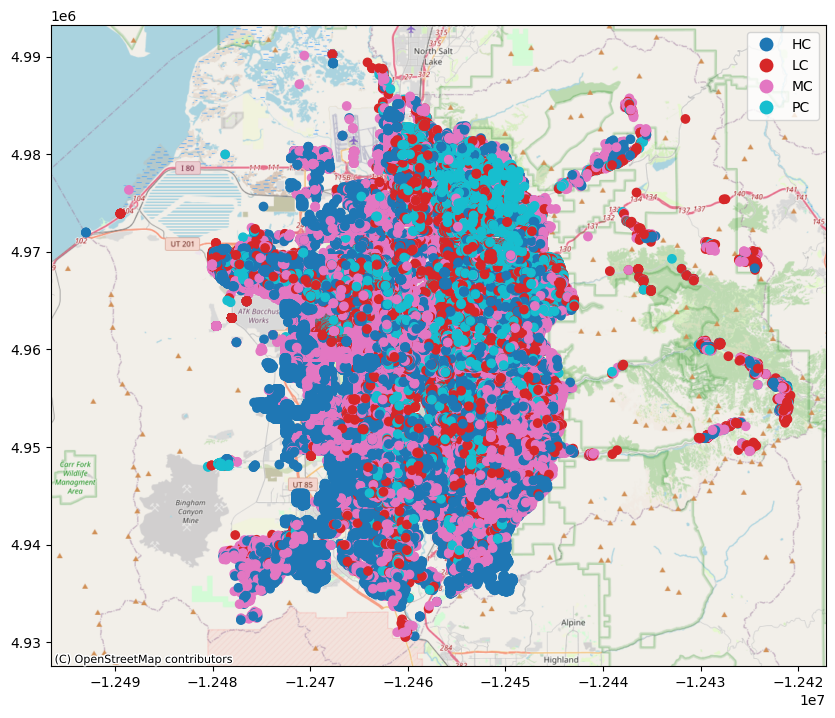

In [20]:
map = viz.plot_gdf_map(bldg_inv_gdf,column='dlevel')
map

#### Use Tract ID to find county FIPS code
The first 5 digits of the tract ID are the FIPS code for the county.

In [21]:
bldg_inv_gdf['tract_id'].describe()

count    2.849250e+05
mean     4.903511e+10
std      4.125693e+03
min      4.903510e+10
25%      4.903511e+10
50%      4.903511e+10
75%      4.903511e+10
max      4.903511e+10
Name: tract_id, dtype: float64

In [22]:
# Substring of tractid to get county 5 digit fips code 
# covert tract_id to string with leading zeros
bldg_inv_gdf['tract_id_str'] = bldg_inv_gdf['tract_id'].astype(str).str.zfill(11)
bldg_inv_gdf['county'] = bldg_inv_gdf['tract_id_str'].str[:5]
bldg_inv_gdf[['tract_id_str','county']].describe()

,tract_id_str,county
count,284925,284925
unique,193,1
top,49035113104,49035
freq,8331,284925


### Building Inventory File has 1 county
The Salt Late City building inventory only has 1 county.

## Generate Address Point Inventory


In [23]:
Nofal_residential_archetypes = { 
        1 : 'One-story sf residential building on a crawlspace foundation',
        2 : 'One-story mf residential building on a slab-on-grade foundation',
        3 : 'Two-story sf residential building on a crawlspace foundation',
        4 : 'Two-story mf residential building on a slab-on-grade foundation'}

HAZUS_residential_archetypes = { 
    "RES1" : "Single Family Dwelling",
    "RES2" : "Mobile / Manufactured Home",
    "RES3A" : "Duplex",
    "RES3B" : "3-4 Units",
    "RES3C" : "5-9 Units",
    "RES3D" : "10-19 Units",
    "RES3E" : "20-49 Units",
    "RES3F" : "50+ Units",
    "RES4" : "Temporary Lodging",
    "RES5" : "Institutional Dormitory",
    "RES6" : "Nursing Home"
    }

residential_archetypes = HAZUS_residential_archetypes 

In [24]:
for community in communities.keys():
    print("Address point inventory for: "+community)
    print("Based on building inventory: "+bldg_inv_id)
    generate_addpt_df = generate_addpt_functions(
                        community =   community,
                        communities = communities,
                        hui_df = housing_unit_inv_df,
                        bldg_inv_gdf = bldg_inv_gdf,
                        bldg_inv_id = bldg_inv_id,
                        residential_archetypes = residential_archetypes,
                        archetype_var = 'archetype',
                        building_area_var = 'sq_foot',
                        building_area_cutoff = 300,
                        seed =          seed,
                        version =       version,
                        version_text=   version_text,
                        basevintage=    basevintage,
                        outputfolder=   outputfolder
                        )

    addpt_dataset_id = generate_addpt_df.generate_addpt_v2_for_incore()

Address point inventory for: SaltLakeCity_UT
Based on building inventory: 62fea288f5438e1f8c515ef8
***************
Address Point Inventory Workflow
***************

Generating Address Point Inventory v2.0.0 data for Salt Lake City, UT
Connection successful to IN-CORE services. pyIncore version detected: 1.7.0
Number of datasets matching Address Point Inventory v2.0.0 data for Salt Lake City, UT: 0
Dataset Address Point Inventory v2.0.0 data for Salt Lake City, UT does not exist in IN-CORE
***************
Obtaining Census Block, Place, and PUMA Data
***************

File already exists: c:\Users\nathanael99\MyProjects\IN-CORE\Tasks\PublishHUIv2\HousingUnitInventories_2022-03-03\ReplicationCode\intersect-community-data/OutputData/tl_2010_SaltLakeCity_UT_tabblockplacepuma10EPSG4269.csv
Converting blk104269 to Geodataframe
***************
Predicting Housing Unit Estimates
***************

File already existsc:\Users\nathanael99\MyProjects\IN-CORE\Tasks\PublishHUIv2\HousingUnitInventories_2

In [25]:
addpt_dataset_id.head()

,addrptid,guid,strctid,blockid,placeGEOID10,placeNAME10,COUNTYFP10,BLOCKID10_str,huestimate,residential,bldgobs,flag_ap,archetype,x,y
0,STc64d6569-ff3e-410d-a1ad-213af6ba463cAP000000,c64d6569-ff3e-410d-a1ad-213af6ba463c,STc64d6569-ff3e-410d-a1ad-213af6ba463c,490351001001006,4967000,Salt Lake City,35,B490351001001006,0.0,0,1,0,COM3,-111.917751,40.805141
1,ST823c82ce-5dd9-49e9-b8c9-01a02a1d1bf6AP000000,823c82ce-5dd9-49e9-b8c9-01a02a1d1bf6,ST823c82ce-5dd9-49e9-b8c9-01a02a1d1bf6,490351001001006,4967000,Salt Lake City,35,B490351001001006,0.0,0,1,0,COM3,-111.917751,40.805141
2,ST45b8a6a6-4101-4967-b296-0be6837ddfe9AP000000,45b8a6a6-4101-4967-b296-0be6837ddfe9,ST45b8a6a6-4101-4967-b296-0be6837ddfe9,490351001001006,4967000,Salt Lake City,35,B490351001001006,0.0,0,1,0,COM3,-111.917751,40.805141
3,STe176ee84-c869-47fe-a825-9854d9cb2bcaAP000000,e176ee84-c869-47fe-a825-9854d9cb2bca,STe176ee84-c869-47fe-a825-9854d9cb2bca,490351001001006,4967000,Salt Lake City,35,B490351001001006,4.0,1,1,0,RES3D,-111.916801,40.804502
4,STe176ee84-c869-47fe-a825-9854d9cb2bcaAP000001,e176ee84-c869-47fe-a825-9854d9cb2bca,STe176ee84-c869-47fe-a825-9854d9cb2bca,490351001001006,4967000,Salt Lake City,35,B490351001001006,4.0,1,0,0,RES3D,-111.916801,40.804502


In [26]:
# descibe addrptid	guid	strctid	blockid
addpt_dataset_id[['addrptid','guid','strctid','BLOCKID10_str']].describe().T

,count,unique,top,freq
addrptid,491867,491867,STc64d6569-ff3e-410d-a1ad-213af6ba463cAP000000,1
guid,474730,284925,4642fad7-29b1-4311-9d70-aa5896d07ece,172
strctid,491867,285535,C00000000000000000000B490351133062000,403
BLOCKID10_str,491867,12504,B490351126122027,1664


### Read in Address Point Inventory
The address point inventory is an intermediate file based on the building inventory. The address point inventory acts as the bridge between the building inventory and the housing unit inventory.

In [27]:
# Check if addpt_dataset_id is string
if isinstance(addpt_dataset_id, str):
    print("The Address Point Inventory ID is a pandas string")
    # Address Point inventory
    addpt_inv_id = addpt_dataset_id
    # load housing unit inventory as pandas dataframe
    addpt_inv = Dataset.from_data_service(addpt_inv_id, data_service)
    filename = addpt_inv.get_file_path('csv')
    print("The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: "+filename)
    addpt_inv_df = pd.read_csv(filename, header="infer")
# else if addpt_dataset_id is a dataframe
elif isinstance(addpt_dataset_id, pd.DataFrame):
    addpt_inv_df = addpt_dataset_id
    print("The Address Point Inventory ID contains a pandas dataframe")
else:
    print("The Address Point Inventory is not a string or pandas dataframe")

The Address Point Inventory ID contains a pandas dataframe


In [28]:
#addpt_inv_df = pd.read_csv(filename, header="infer")
addpt_inv_df['addrptid'].describe()

count                                             491867
unique                                            491867
top       STc64d6569-ff3e-410d-a1ad-213af6ba463cAP000000
freq                                                   1
Name: addrptid, dtype: object

## Step 2: Housing Unit Allocation v2

### Setup Housing Unit Allocation

### Run Housing Unit Allocation

In [38]:
for community in communities.keys():
    print("Housing Unit Allocation for: "+community)
    print("Based on housing unit inventory: "+hui_dataset_id)
    print("Based on building inventory: "+bldg_inv_id)

    outputfolders = directory_design(state_county_name = community,
                                            outputfolder = outputfolder)

    run_hua_gdf = hua_workflow_functions(
                        community =   community,
                        hui_df = housing_unit_inv_df,
                        bldg_df = bldg_inv_gdf,
                        addpt_df = addpt_inv_df,
                        seed =          seed,
                        version =       version,
                        version_text=   version_text,
                        basevintage=    basevintage,
                        outputfolder=   outputfolder,
                        outputfolders = outputfolders
                        )

    hua_gdf = run_hua_gdf.housing_unit_allocation_workflow()

Housing Unit Allocation for: SaltLakeCity_UT
Based on housing unit inventory: 630e8b03f5438e1f8c51d7c2
Based on building inventory: 62fea288f5438e1f8c515ef8
Running up Housing Unit Allocation for SaltLakeCity_UT


KeyError: 'top'

In [39]:
outputfolders

{'top': 'OutputData/SaltLakeCity_UT',
 'logfiles': 'OutputData/SaltLakeCity_UT/00_logfiles',
 'CommunitySourceData': 'OutputData/SaltLakeCity_UT/01_CommunitySourceData',
 'TidyCommunitySourceData': 'OutputData/SaltLakeCity_UT/02_TidyCommunitySourceData',
 'BaseInventory': 'OutputData/SaltLakeCity_UT/03_BaseInventory',
 'RandomMerge': 'OutputData/SaltLakeCity_UT/04_RandomMerge',
 'Verify': 'OutputData/SaltLakeCity_UT/05_Verify',
 'Explore': 'OutputData/SaltLakeCity_UT/06_Explore',
 'Uncertainty_propagation': 'OutputData/SaltLakeCity_UT/07_Uncertainty_propagation',
 'Validation': 'OutputData/SaltLakeCity_UT/08_Validation'}

In [29]:
def housing_unit_allocation_workflow():
    '''
    Workflow to run housing unit allocation functions
    Returns a pandas dataframe with the housing unit allocation
    Each observation is a housing unit allocated to an address point
    Each address point is allocated to a building if there is a building 
    within the census block or nearby block group.
    '''
    for community in communities.keys():
        # Create empty container to store outputs for in-core
        # Will use these to combine multiple counties
        hua_incore_county_df = {}
        print("Setting up Housing Unit Inventory for",communities[community]['community_name'])

        # Set up output file and check if it exists
        output_filename = f'hua_{version_text}_{community}_{basevintage}_rs{seed}'
        csv_filepath = outputfolders['top']+"/"+output_filename+'.csv'
        savefile = sys.path[0]+"/"+csv_filepath
        if os.path.exists(savefile):
            print("The file already exists: "+savefile)
            huav2_gdf = gpd.read_file(csv_filepath)
            return huav2_gdf

        for county in communities[community]['counties'].keys():
            state_county = communities[community]['counties'][county]['FIPS Code']
            state_county_name  = communities[community]['counties'][county]['Name']
            print(state_county_name,': county FIPS Code',state_county)
        
            outputfolders = directory_design(state_county_name = state_county_name,
                                                outputfolder = outputfolder)
                                                
            generate_df = hua_workflow_functions(
                hui_df = housing_unit_inv_df,
                addpt_df=addpt_inv_df,
                bldg_df=bldg_inv_gdf,
                state_county = state_county,
                state_county_name= state_county_name,
                seed = seed,
                version = version,
                version_text = version_text,
                basevintage = basevintage,
                outputfolder = outputfolder,
                outputfolders = outputfolders)

            # Generate base housing unit inventory
            base_hua_df = generate_df.run_hua_workflow(savelog=False)

            # Save version for IN-CORE in v2 format
            hua_incore_county_df[state_county] = base_hua_df['primary']

        # combine multiple counties
        hua_incore_df = pd.concat(hua_incore_county_df.values(), 
                                        ignore_index=True, axis=0)

        # Convert HUA to geodataframe format
        hua_incore_gdf = gpd.GeoDataFrame(
            hua_incore_df, geometry=gpd.points_from_xy(hua_incore_df.x, hua_incore_df.y))

        # Merge building inventory with housing unit allocation results
        huav2_gdf = pd.merge(left = hua_incore_gdf, 
                            right = bldg_inv_gdf[['guid','archetype','geometry']], 
                            on='guid', how='outer')

        # If Geometry is null, use X,Y coordinates from Address Point
        # use geometry_y unless missing - then use geometry_x
        huav2_gdf['geometry'] = huav2_gdf['geometry_y']
        huav2_gdf.loc[huav2_gdf['geometry'].isnull(), 'geometry'] = huav2_gdf['geometry_x']
        # drop geometry_x and geometry_y columns
        huav2_gdf.drop(columns=['geometry_x','geometry_y'], inplace=True)

        # Convert Block2010 to string
        # fill in missing values
        huav2_gdf['Block2010'] = huav2_gdf['Block2010'].fillna(999999999999999)
        huav2_gdf['Block2010'] = huav2_gdf['Block2010'].apply(lambda x : str(int(x)).zfill(15))

        #Save results for community name
        huav2_gdf.to_csv(savefile, index=False)
    return huav2_gdf


Setting up Housing Unit Inventory for Salt Lake City, UT
Salt Lake City County, UT : county FIPS Code 49035

***************************************
    Run Housing Unit Allocation for Salt Lake City County, UT
***************************************


***************************************
    Merge housing unit and address point data with first 3 counters.
***************************************

Round 1

***************************************
***************************************

Performing random merge at geography level: Block

***************************************
***************************************


***************************************
***************************************

Attempt to merge hui on all common group vars.

***************************************
***************************************

Running random merge by ['Block2010', 'huicounter1', 'ownershp1']

***************************************
    Setting up  primary data with primary key and flags
*

## Check block with missing huid match


In [30]:
huav2_gdf.head()

,huid,Block2010,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,strctid_Block2010_flagsetrm,addrptid,guid,huestimate,huicounter_addpt,placeNAME10,x,y,archetype,geometry
0,B490351001001006H001,490351001001006,4.903510e+14,4.903510e+11,4.903510e+10,49035.0,1.0,2.0,1.0,0.0,...,1.0,STf81a2628-4647-4f6c-8635-0ff7aaa98c27AP000000,f81a2628-4647-4f6c-8635-0ff7aaa98c27,6.0,1.0,Salt Lake City,-111.917033,40.804688,RES5,POINT (-111.91703 40.80469)
1,B490351001001006H012,490351001001006,4.903510e+14,4.903510e+11,4.903510e+10,49035.0,1.0,2.0,1.0,0.0,...,1.0,STf81a2628-4647-4f6c-8635-0ff7aaa98c27AP000001,f81a2628-4647-4f6c-8635-0ff7aaa98c27,6.0,2.0,Salt Lake City,-111.917033,40.804688,RES5,POINT (-111.91703 40.80469)
2,B490351001001006H013,490351001001006,4.903510e+14,4.903510e+11,4.903510e+10,49035.0,1.0,2.0,1.0,0.0,...,1.0,STf81a2628-4647-4f6c-8635-0ff7aaa98c27AP000002,f81a2628-4647-4f6c-8635-0ff7aaa98c27,6.0,3.0,Salt Lake City,-111.917033,40.804688,RES5,POINT (-111.91703 40.80469)
3,B490351001001006H002,490351001001006,4.903510e+14,4.903510e+11,4.903510e+10,49035.0,1.0,2.0,1.0,0.0,...,1.0,STe176ee84-c869-47fe-a825-9854d9cb2bcaAP000001,e176ee84-c869-47fe-a825-9854d9cb2bca,4.0,2.0,Salt Lake City,-111.916801,40.804502,RES3D,POINT (-111.91680 40.80450)
4,B490351001001006H003,490351001001006,4.903510e+14,4.903510e+11,4.903510e+10,49035.0,1.0,2.0,1.0,0.0,...,1.0,STe176ee84-c869-47fe-a825-9854d9cb2bcaAP000002,e176ee84-c869-47fe-a825-9854d9cb2bca,4.0,3.0,Salt Lake City,-111.916801,40.804502,RES3D,POINT (-111.91680 40.80450)


In [31]:
from pyncoda.ncoda_04b_foliummaps import *

In [1]:
map_selected_block(huav2_gdf, blocknum='490351001001006')


NameError: name 'map_selected_block' is not defined

In [44]:
# Check guid with missing address point id
condition1 = (huav2_gdf['archetype'] == 'RES5')
gdf1 = huav2_gdf.loc[condition1].copy()

folium_marker_layer_map(gdf = huav2_gdf,
                        gdfvar="race",
                        layername = "",
                        color_levels = [0,1,2,3,4,5,6,7])